### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Reading Data

In [2]:
df = pd.read_excel('Adops & Data Scientist Sample Data.xlsx', sheet_name='Q2 Regression', header=None)
df.rename(columns = {0:'A',1:'B',2:'target'}, inplace = True) 

In [3]:
print(df['target'].nlargest(10))
print(" ")
print(df['target'].nsmallest(10))

248    202.022916
284    164.705837
213    164.059058
242    155.383323
234    154.329356
202    142.858157
220    139.941708
282    126.803279
203    126.380004
211    117.257016
Name: target, dtype: float64
 
200   -9999.000000
298    -315.397489
229    -289.174093
259    -287.963053
275    -286.055387
293    -285.565482
225    -281.045024
208    -252.264946
209    -248.194614
294    -195.148227
Name: target, dtype: float64


### 200th row seems like an outlier/missing value. For this time, I will just drop it.

In [4]:
df.drop(200, inplace=True)

### EDA: Check the linearity

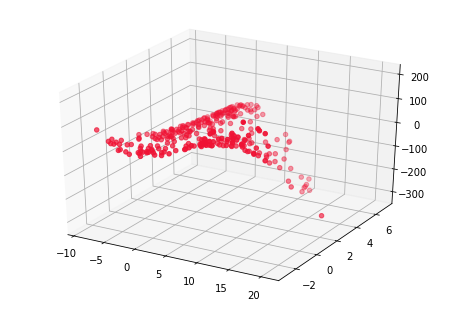

In [5]:
first = df['A'].values
second = df['B'].values
target = df['target'].values

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(first, second, target, color='#ef1234')
plt.show()

### Clearly seeing the linear relationship - possibly polynomial regression as I see some curve.

### Setting up evaluation metrics

In [6]:
def rmse(Y, Y_pred):
    '''
Compute Root Mean Squared Error value by putting in the actual Y value and predicted Y value
    '''
    rmse = np.sqrt(sum((Y - Y_pred) ** 2) / len(Y))
    return rmse

def r2_score(Y, Y_pred):
    '''
Compute the coefficient of determination by putting in the actual Y value and predicted Y value
    '''
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

### Basic linear regression with the equation of Y_pred = B0X0 + B1X1

In [7]:
def LinearRegression(X_df,Y_target):
    '''
Predict Y value based on X - putting in the dataframe with predictors and target.
Evaluate the prediction with RMSE and R2, display beta coefficients of each features. 
    '''
    X = np.array(X_df)
    Y = np.array(Y_target)
    B = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    '''
Referenced the equation from https://en.wikipedia.org/wiki/Ordinary_least_squares#Matrix/vector_formulation
Beta = (X^T X)^-1 (X^T)Y 
    '''
    Y_pred = X.dot(B)
    print("RMSE")
    print(rmse(Y, Y_pred))
    print("R2 Score")
    print(r2_score(Y, Y_pred))
    print("Beta Coefficients")
    print(B)
    return None

In [8]:
LinearRegression(df[['A','B']],target)

RMSE
58.76001170278232
R2 Score
0.3194001016450263
Beta Coefficients
[  0.05232    -11.38516498]


### Better than expected for beginning. As R2 score is 0.319 (somewhat distant from score of 1), the model is too simple at this point.

### I will standardize the data before polynomial regression - as polynomial expansion multiplies features, it is good to standardize considering the colinearity

In [11]:
df['A_std'] = (df['A'] - np.mean(df['A']))/(np.std(df['A']))
df['B_std'] = (df['B'] - np.mean(df['B']))/(np.std(df['B']))
df.head()

,A,B,target,A_std,B_std
0,0.490142,-0.179654,11.536508,-0.317187,-0.738446
1,-1.414793,-1.225605,11.828531,-0.652752,-1.088442
2,0.943066,4.506148,-3.235349,-0.237402,0.829520
3,3.569090,5.068347,-23.891922,0.225188,1.017644
4,-1.702460,6.905051,-22.125437,-0.703426,1.632243


### Let's try polynomial regression: Writing a function that would return the polynomial features of input for desired degree.

#### To be honest, I frustrated a lot for this portion - after discussing with my colleagues and referencing the web, I found that there is a method using recursive programming with Python List. I found this function works only until 2 degree. (which is sufficient for this dataset)

In [13]:
def poly_feats(feature_lst, degree):
    '''Recursive Programming: As polynomial features will be added in addition to existing one
Considering that you have to add new value, List would be better than Pandas

For degree of 1, just adding constant.
If degree is higher than 1, using nested for loops to generate polynomial features

ex: two features with degree of 2
[A,B,C]  (constant C is added)
[A,B,C][A,B,C] (Squaring)
A2 AB AC BA B2 BC CA CB C2 (Expanded)
A2 2AB 2AC B2 2BC C2 (Combining)
=> six polynomial features at the end
    '''

    if degree==1:
        if 1 not in feature_lst:
            result = feature_lst.insert(0,1)
        result=feature_lst
        return result
    elif degree > 1:
        new_result=[]
        result = poly_feats(feature_lst, degree-1)
        new_result.extend(result)
        for item in feature_lst:
            for p_item in result:
                res=item*p_item
                if (res not in result) and (res not in new_result):
                    new_result.append(res)
        return new_result

def get_poly_feats(df, degree):
    
    '''
Performing Polynomial Feature Generation (function above) with Pandas dataframe.
    '''

    result = {}
    for i, r in df.iterrows():
        result[i] = poly_feats(r.tolist(), degree)
    return pd.DataFrame(result).transpose()

In [14]:
first_ply = get_poly_feats(df[['A_std','B_std']],1)

In [15]:
first_ply.head()

,0,1,2
0,1.0,-0.317187,-0.738446
1,1.0,-0.652752,-1.088442
2,1.0,-0.237402,0.829520
3,1.0,0.225188,1.017644
4,1.0,-0.703426,1.632243


In [16]:
LinearRegression(first_ply,target)

RMSE
55.44826106180801
R2 Score
0.39395622620298865
Beta Coefficients
[ -8.2650947   -7.77896044 -45.5020302 ]


### Even adding a constant to same equation improves the model - it indicates that our current model is too simple.

In [17]:
second_ply = get_poly_feats(df[['A_std','B_std']],2)
second_ply.head()

,0,1,2,3,4,5
0,1.0,-0.317187,-0.738446,0.100607,0.234225,0.545302
1,1.0,-0.652752,-1.088442,0.426085,0.710483,1.184707
2,1.0,-0.237402,0.829520,0.056360,-0.196929,0.688104
3,1.0,0.225188,1.017644,0.050709,0.229161,1.035599
4,1.0,-0.703426,1.632243,0.494808,-1.148163,2.664217


In [18]:
LinearRegression(second_ply,target)

RMSE
33.54618459379427
R2 Score
0.7781730042334817
Beta Coefficients
[ -4.20179626  -9.20666051 -51.45591732 -15.30175074 -45.6830401
   2.69608969]


### The regression model with 2nd Degree Polynomial Features shows great performance. 0.778 indicates that 77.8% of observation within data is explained by the model.

### Bonus: Additional degree

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
thirdpoly = PolynomialFeatures(degree=3)
thirdfeatures = thirdpoly.fit_transform(df[['A_std','B_std']])
LinearRegression(thirdfeatures,target)

RMSE
9.952909770568788e-06
R2 Score
0.9999999999999805
Beta Coefficients
[ 4.24498800e+00 -9.73551753e+00 -1.52381702e+01 -2.61309042e+01
 -3.10897487e+01  1.09649527e-07 -5.93512519e-08 -3.85224154e+01
  4.78812314e-07  7.60485278e-07]


In [21]:
fourthpoly = PolynomialFeatures(degree=4)
fourthfeatures = fourthpoly.fit_transform(df[['A_std','B_std']])
LinearRegression(fourthfeatures,target)

RMSE
9.824936337625715e-06
R2 Score
0.999999999999981
Beta Coefficients
[ 4.24499001e+00 -9.73551771e+00 -1.52381696e+01 -2.61309047e+01
 -3.10897471e+01 -6.23359017e-06  1.51124354e-07 -3.85224154e+01
  4.06414252e-07  3.62214962e-07 -5.06755580e-08 -2.23616382e-07
  8.50269409e-07 -8.05766661e-07  2.34278470e-06]


### The model clearly shows the overfitting from 3rd degree (describing the noise instead of relationship between features and target - indicates that we don't need that much polynomial features.)